In [1]:
import os, psutil, math
from google.colab import drive

drive.mount('/content/drive')
# Ile realnego RAM-u?
total_gb = math.floor(psutil.virtual_memory().total / 1024**3)
print("Runtime RAM:", total_gb, "GB")

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["PYSPARK_SUBMIT_ARGS"] = (
    "--driver-memory 300g "                 # rozsądny heap
    "--conf spark.driver.maxResultSize=30g "
    "pyspark-shell"
)

from pyspark.sql import SparkSession

NUM_CORES   = os.cpu_count()                 # np. 96
NUM_WORKERS = NUM_CORES                      # używaj wszystkich

spark = (
    SparkSession.builder
        .appName("xgb-fast")
        .master(f"local[{NUM_CORES}]")       # wyraźnie podaj liczbę rdzeni
        # 4×-8× tyle partycji co rdzeni (AQE później je sklei)
        .config("spark.sql.shuffle.partitions", NUM_CORES * 4)
        .config("spark.sql.adaptive.enabled", "true")
        .config("spark.sql.adaptive.coalescePartitions.enabled", "true")
        .getOrCreate()
)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Runtime RAM: 334 GB


In [2]:
from pyspark.ml.feature import VectorAssembler

df = spark.read.parquet("/content/drive/MyDrive/add/ml-latest/output/pred.parquet")

df = df.fillna(0)

"""
SAMPLE_FRAC = 0.01
SEED        = 42

df = df.sample(
    withReplacement=False,
    fraction=SAMPLE_FRAC,
    seed=SEED,
)"""

feature_cols = [c for c in df.columns if c not in ("movieId", "rating")]

num_workers = spark.sparkContext.defaultParallelism
df_vect = (
    df
    .repartition(num_workers)          # równoległość
    .persist()                         # w pamięci
)


assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features"
)
dataset = assembler.transform(df_vect).select("features", "rating")

# split 80/20:
train_df, val_df = dataset.randomSplit([0.8, 0.2], seed=42)

In [4]:
from xgboost.spark import SparkXGBRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import functions as F

xgb_reg = SparkXGBRegressor(
    features_col      ="features",
    label_col         ="rating",
    prediction_col    ="prediction",
    num_workers       =NUM_WORKERS,
    tree_method       ="hist",
    objective         ="reg:squarederror",
    cacheTrainingSet  = True,
    num_boost_round = 50
)


xgb_model = xgb_reg.fit(train_df)

# Predykcje i ocena:
preds = xgb_model.transform(val_df)
evaluator = RegressionEvaluator(
    labelCol="rating",
    predictionCol="prediction",
    metricName="rmse"
)
rmse = evaluator.evaluate(preds)
print(f"Validation RMSE: {rmse:.4f}")

# zaokrąglenie do 0.5
preds = preds.withColumn(
    "prediction",
    F.round(F.col("prediction") * 2) / 2
)

preds.select("prediction", "rating").show(5, truncate=False)


INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 96 workers with
	booster params: {'objective': 'reg:squarederror', 'device': 'cpu', 'tree_method': 'hist', 'cacheTrainingSet': True, 'nthread': 1}
	train_call_kwargs_params: {'num_boost_round': 100, 'verbose_eval': True}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished xgboost training!


Validation RMSE: 0.9737
+----------+------+
|prediction|rating|
+----------+------+
|3.0       |3.0   |
|3.0       |3.5   |
|3.5       |3.5   |
|3.0       |3.5   |
|3.0       |5.0   |
+----------+------+
only showing top 5 rows



In [17]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import functions as F

metrics = {
    "r2":         "R²",
    "rmse":       "RMSE",
    "mae":        "MAE",
    "var":        "Explained variance"
}

for m, label in metrics.items():
    val = RegressionEvaluator(
            labelCol="rating",
            predictionCol="prediction",
            metricName=m
          ).evaluate(preds)
    print(f"{label:20s}: {val:.4f}")

mape = (
    preds
    .withColumn("ape", F.abs((F.col("rating") - F.col("prediction")) / F.col("rating")))
    .agg(F.mean("ape"))
    .first()[0]
)

print(f"{'MAPE':20s}: {mape * 100:.2f}%")


R²                  : 0.1504
RMSE                : 0.9855
MAE                 : 0.7431
Explained variance  : 0.2413
MAPE                : 35.42%


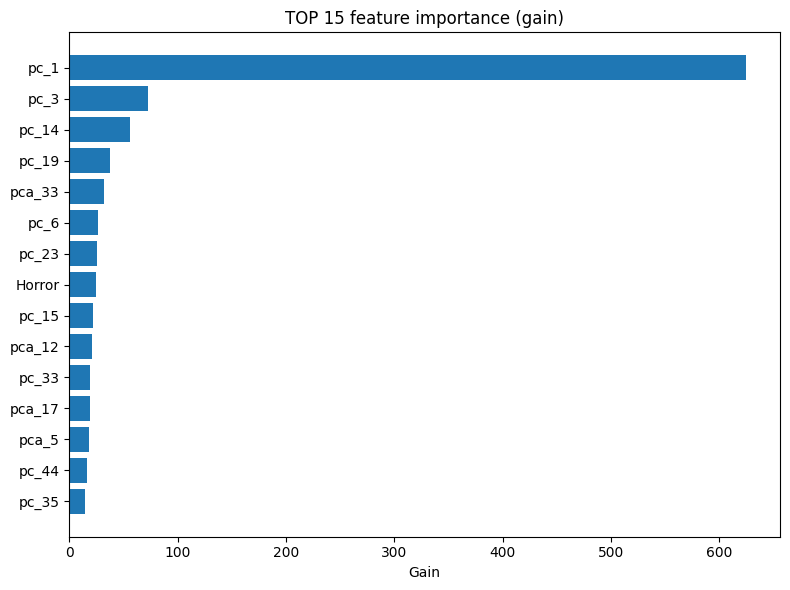

In [16]:
import pandas as pd
import matplotlib.pyplot as plt


MODEL        = xgb_model
FEATURE_COLS = feature_cols
TOP_K        = 15

booster = MODEL.get_booster()                         # xgboost.Booster
raw_imp = booster.get_score(importance_type="gain")


imp_rows = []
for fid, score in raw_imp.items():
    idx = int(fid[1:])
    name = FEATURE_COLS[idx] if idx < len(FEATURE_COLS) else fid
    imp_rows.append((name, score))

df_imp = (pd.DataFrame(imp_rows, columns=["feature", "gain"])
            .sort_values("gain", ascending=False)
            .head(TOP_K)
            .reset_index(drop=True))



plt.figure(figsize=(8, min(12, TOP_K * 0.4)))
plt.barh(df_imp["feature"][::-1], df_imp["gain"][::-1])
plt.title(f"TOP {TOP_K} feature importance (gain)")
plt.xlabel("Gain")
plt.tight_layout()
plt.show()
